# 使用MXNet实现手写数字图像识别
_**本项目介绍在华为云Modelart平台上使用MXNet实现MNIST数据集的手写数字图像识别应用，主要是完成训练脚本的开发。**_


---

##  内容

1. [背景](#背景)
1. [环境配置](#环境配置)
1. [数据准备](#数据准备)
1. [构建神经网络模型](#构建神经网络模型)
1. [展示模型结构](#展示模型结构)
1. [模型训练基本配置](#模型训练基本配置)
1. [模型训练](#模型训练基本配置)
1. [附录](#附录)
---

## 背景


本Notebook将展示如何使用内嵌AI引擎解决实际的手写数字自动识别问题。手写数字只包含0-9，对于任意一张图片，用计算机确定它是0-9中的哪个数字，其本质是图像分类问题。 本文是选用经典AI引擎MXNet，根据其内置功能构建神经网络模型和Softmax回归来解决这一问题。主要内容包括

* 使用notebook的基本环境配置.
* 将格式MNIST数据集用于训练，并且存储到OBS桶中. 
* 用MXNet构建三层神经网络模型.
* 开启模型的训练


---

## 环境配置

本项目无需手动设置，所需的存储桶、目录等都由自动生成，配置内容包括：

* 获取notebook URL, 用于定位项目源文件在容器中位置

In [1]:
import moxing as mox
mox.file.copy_parallel('s3://obs-bdc2020-bj4/traffic_flow_dataset', 's3://anunnaki/myfolder')
print('Copy procedure is completed !')

INFO:root:Using MoXing-v1.14.1-ddfd6c9a
INFO:root:Using OBS-Python-SDK-3.1.2


Copy procedure is completed !


In [2]:
# 本地存储的项目目录, 设置系统路径
import os,sys
source_file_path = os.environ['HOME'] + '/work/' + URL.split("/")[-2] + '/'
print(source_file_path)

/home/ma-user/work/mxnet_mnist_digit_recognition_train/


本项目需要配置的内容为导入所依赖的Python库.

In [3]:
import urllib3
urllib3.disable_warnings()
import os     
import logging
import mxnet as mx           
import matplotlib.pyplot as plt
import time
import gzip
from six.moves import urllib

logging.basicConfig(level=logging.INFO)

---
## 数据准备

本项目的数据集MNIST来自美国国家标准与技术研究所(NIST),其分为训练集和测试集，训练集有60000张图片，测试集有10000张图片,每张图片都有标签。数据集开源地址： http://yann.lecun.com/exdb/mnist/ ，将数据集下载至notebook容器中，训练时去容器中去读数据集。共有四部分：
* train-images-idx3-ubyte.gz (训练集样本)
* train-labels-idx1-ubyte.gz (训练集标签)
* t10k-images-idx3-ubyte.gz (测试集样本)
* t10k-labels-idx1-ubyte.gz (测试集标签)

In [4]:
dataset_url = "https://modelarts-cnnorth1-market-dataset.obs.cn-north-1.myhuaweicloud.com/dataset-market/Mnist-Data-Set/archiver/Mnist-Data-Set.zip"
dataset_file_names = ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz", "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]
dataset_local_path = source_file_path + 'dataset/'
dataset_local_name = dataset_local_path + 'Mnist-Data-Set.zip' 
!wget {dataset_url} -P {dataset_local_path}

!unzip -d {dataset_local_path} -o {dataset_local_name}

--2019-11-30 14:41:42--  https://modelarts-cnnorth1-market-dataset.obs.cn-north-1.myhuaweicloud.com/dataset-market/Mnist-Data-Set/archiver/Mnist-Data-Set.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 23192478 (22M) [application/octet-stream]
Saving to: ‘/home/ma-user/work/mxnet_mnist_digit_recognition_train/dataset/Mnist-Data-Set.zip.2’

Mnist-Data-Set.zip. 100%[===================>]  22.12M  --.-KB/s    in 0.1s    

2019-11-30 14:41:43 (153 MB/s) - ‘/home/ma-user/work/mxnet_mnist_digit_recognition_train/dataset/Mnist-Data-Set.zip.2’ saved [23192478/23192478]

Archive:  /home/ma-user/work/mxnet_mnist_digit_recognition_train/dataset/Mnist-Data-Set.zip
  inflating: /home/ma-user/work/mxnet_mnist_digit_recognition_train/dataset/t10k-images-idx3

In [5]:
! ls $dataset_local_path

-0001.params	      t10k-images-idx3-ubyte	 train-images-idx3-ubyte.gz
Mnist-Data-Set.zip    t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte
Mnist-Data-Set.zip.1  t10k-labels-idx1-ubyte	 train-labels-idx1-ubyte.gz
Mnist-Data-Set.zip.2  t10k-labels-idx1-ubyte.gz
-symbol.json	      train-images-idx3-ubyte


In [6]:
train_image = os.path.join(dataset_local_path, 'train-images-idx3-ubyte')
train_lable = os.path.join(dataset_local_path, 'train-labels-idx1-ubyte')
eval_image  = os.path.join(dataset_local_path, 't10k-images-idx3-ubyte')
eval_lable  = os.path.join(dataset_local_path, 't10k-labels-idx1-ubyte')

构建训练和测试迭代器，mx.io.MNISTIter, 可用于通过next方法访问下一组数据

In [7]:
batch_size = 128
train_data = mx.io.MNISTIter(image = train_image,
                             label = train_lable,
                             data_shqpe = (1,28,28),
                             batch_size = batch_size,
                             shuffle = True,
                             flat    = False,
                             silent  = False)

eval_data  = mx.io.MNISTIter(image = eval_image,
                             label = eval_lable,
                             data_shqpe = (1,28,28),
                             batch_size = batch_size,
                             shuffle = False)

从数据集中选择几张图片+标签并输出，需要做格式的转换后才能展示.

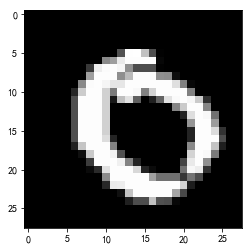

label: 0


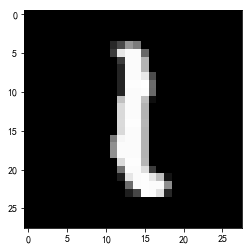

label: 1


In [8]:
train_data.reset()
next_batch  =  train_data.next()

show_image  =  next_batch.data[0][0].asnumpy() * 255      
show_image  =  show_image.astype('uint8').reshape(28, 28)
fig         =  plt.figure() 
plt.imshow(show_image, cmap = plt.cm.gray)
plt.show()
print('label: ' + str(int(next_batch.label[0][0].asscalar())))

show_image  =  next_batch.data[0][10].asnumpy() * 255      
show_image  =  show_image.astype('uint8').reshape(28, 28)
plt.imshow(show_image, cmap = plt.cm.gray)
plt.show()
print('label: ' + str(int(next_batch.label[0][10].asscalar())))

---
## 构建神经网络模型

利用MXNet构建三层神经网络模型.

In [9]:
num_classes= 10
data    = mx.symbol.Variable('data')
data    = mx.sym.Flatten(data=data)            
fc1     = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
act1    = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
fc2     = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2    = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
fc3     = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=num_classes)
mlp     = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

## 展示模型结构

展示全连接神经网络模型结构，包括输入层、中间层和输出层.

In [10]:
!pip install graphviz

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


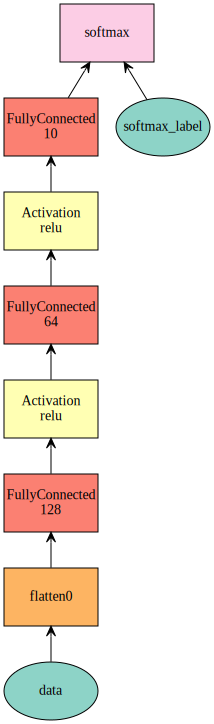

In [11]:
mx.viz.plot_network(mlp)

展示神经网络模型各层的参数信息.

In [12]:
mx.viz.print_summary(mlp, {"data":(32,1,28,28),})      

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          1x28x28                 0                                           
________________________________________________________________________________________________________________________
flatten0(Flatten)                                   784                     0           data                            
________________________________________________________________________________________________________________________
fc1(FullyConnected)                                 128                     100480      flatten0                        
________________________________________________________________________________________________________________________
relu1(Activation)               

## 模型训练基本配置

模型参数初始化，以及训练后的模型输出路径等。

In [13]:
devs  = mx.cpu()                                     
#创建模型
model = mx.mod.Module(context=devs, symbol = mlp)     
print(model._param_names)

#设置参数同步方式
kv = mx.kvstore.create('local')                       
learning_rate  = 0.01
weight_decay   = 0.0001
optimizer_params = {'learning_rate':learning_rate, 'wd':weight_decay}

#模型参数初始化
initializer    = mx.init.Xavier(rnd_type = 'gaussian', factor_type = "in", magnitude = 2)    
#设置日志打印频率
batch_end_callbacks  = [mx.callback.Speedometer(batch_size, 50)]              
#epoch间隔保存模型参数,当前保存在container中
epoch_end_callbacks  = [mx.callback.do_checkpoint(dataset_local_path, 1)]              

['fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'fc3_weight', 'fc3_bias']


---
## 模型训练

开始训练，训练精度会直接输出

In [14]:
model.fit(train_data  = train_data,
          eval_data   = eval_data,        
          begin_epoch = 0,
          num_epoch   = 1,                                 #epoch=1： 所有数据集都输入用于训练一次
          eval_metric = ['accuracy'],
          kvstore     = kv,    
          optimizer   = 'sgd',   
          optimizer_params = optimizer_params,
          initializer      = initializer,
          arg_params  = None,
          aux_params  = None,
          batch_end_callback = batch_end_callbacks,
          epoch_end_callback = epoch_end_callbacks,
          allow_missing = True)   
print("train over.")

INFO:root:Epoch[0] Batch [50]	Speed: 117050.51 samples/sec	accuracy=0.211244
INFO:root:Epoch[0] Batch [100]	Speed: 80923.03 samples/sec	accuracy=0.437188
INFO:root:Epoch[0] Batch [150]	Speed: 78268.14 samples/sec	accuracy=0.605000
INFO:root:Epoch[0] Batch [200]	Speed: 79907.91 samples/sec	accuracy=0.726250
INFO:root:Epoch[0] Batch [250]	Speed: 113351.43 samples/sec	accuracy=0.757500
INFO:root:Epoch[0] Batch [300]	Speed: 80918.40 samples/sec	accuracy=0.795156
INFO:root:Epoch[0] Batch [350]	Speed: 77380.33 samples/sec	accuracy=0.817500
INFO:root:Epoch[0] Batch [400]	Speed: 78835.21 samples/sec	accuracy=0.825000
INFO:root:Epoch[0] Batch [450]	Speed: 117002.56 samples/sec	accuracy=0.840313
INFO:root:Epoch[0] Train-accuracy=0.844238
INFO:root:Epoch[0] Time cost=0.705
INFO:root:Saved checkpoint to "/home/ma-user/work/mxnet_mnist_digit_recognition_train/dataset/-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.855168


train over.


## 附录

* [MXNet函数请参考](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html)